# Stochastic variational inference in the TrueSkill model

In [4]:
!pip install wget
from functools import partial
from scipy.stats import norm
from torch import nn
from torch.distributions.normal import Normal
from tqdm import trange, tqdm_notebook
import matplotlib.pyplot as plt, numpy as np, os, os.path, pandas as pd, random, scipy.io, scipy.stats, torch, wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=7a43f5801c0477fdbef0a88ac59df2c40877bea5c4a271895fbbd31604d5d31e
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [5]:
def diag_gaussian_log_density(x, mu, std):
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 20.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_20_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_20_times(z1, z2))

def log_posterior_beat_each_other_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 20.* logp_a_beats_b(z1, z2) + 20.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_20_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_20_times(z1, z2))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

def batch_elbo(logprob, mean, log_std, num_samples):
    z = diag_gaussian_samples(mean, log_std, num_samples)
    return torch.mean(logprob(z) - diag_gaussian_logpdf(z, mean, log_std))

def log_posterior_A_beat_B_20_times_1_arg(z1z2):
    return log_posterior_A_beat_B_20_times(z1z2[:, 0], z1z2[:, 1]).flatten()

Optimizing variational parameters...


  1%|          | 14/1200 [00:00<00:21, 56.24it/s]

Iteration 0 lower bound 32.32929611206055
Iteration 25 lower bound 27.63042640686035


  5%|▌         | 63/1200 [00:00<00:09, 116.72it/s]

Iteration 50 lower bound 16.75616455078125


  8%|▊         | 100/1200 [00:00<00:07, 148.75it/s]

Iteration 75 lower bound 10.682066917419434
Iteration 100 lower bound 8.972249984741211


 13%|█▎        | 152/1200 [00:01<00:06, 156.23it/s]

Iteration 125 lower bound 7.723330020904541
Iteration 150 lower bound 5.638054847717285


 16%|█▋        | 196/1200 [00:01<00:05, 182.62it/s]

Iteration 175 lower bound 4.928311347961426
Iteration 200 lower bound 4.957226753234863


 22%|██▏       | 258/1200 [00:01<00:03, 243.01it/s]

Iteration 225 lower bound 4.660233020782471
Iteration 250 lower bound 4.606812953948975
Iteration 275 lower bound 4.399464130401611


 27%|██▋       | 320/1200 [00:01<00:03, 259.57it/s]

Iteration 300 lower bound 4.477982997894287
Iteration 325 lower bound 4.390694618225098


 31%|███       | 371/1200 [00:02<00:03, 217.98it/s]

Iteration 350 lower bound 4.076167583465576
Iteration 375 lower bound 3.92828631401062


 37%|███▋      | 447/1200 [00:02<00:03, 225.70it/s]

Iteration 400 lower bound 3.9700417518615723
Iteration 425 lower bound 3.9714608192443848


 39%|███▉      | 470/1200 [00:02<00:03, 217.44it/s]

Iteration 450 lower bound 3.9488730430603027
Iteration 475 lower bound 4.043783664703369


 46%|████▋     | 557/1200 [00:02<00:02, 261.23it/s]

Iteration 500 lower bound 3.859837055206299
Iteration 525 lower bound 4.014284133911133
Iteration 550 lower bound 3.957791566848755


 52%|█████▏    | 623/1200 [00:03<00:02, 262.24it/s]

Iteration 575 lower bound 3.8258652687072754
Iteration 600 lower bound 3.9748377799987793
Iteration 625 lower bound 3.884690761566162


 56%|█████▌    | 673/1200 [00:03<00:03, 173.54it/s]

Iteration 650 lower bound 3.936257839202881
Iteration 675 lower bound 4.123719215393066


 62%|██████▏   | 740/1200 [00:03<00:02, 192.24it/s]

Iteration 700 lower bound 4.112035274505615
Iteration 725 lower bound 3.832639217376709


 65%|██████▌   | 783/1200 [00:04<00:02, 201.49it/s]

Iteration 750 lower bound 4.04268741607666
Iteration 775 lower bound 3.900792360305786


 69%|██████▉   | 828/1200 [00:04<00:01, 204.23it/s]

Iteration 800 lower bound 3.986811399459839
Iteration 825 lower bound 3.9227359294891357


 71%|███████   | 849/1200 [00:04<00:01, 181.02it/s]

Iteration 850 lower bound 3.8216915130615234


 74%|███████▎  | 884/1200 [00:04<00:02, 120.12it/s]

Iteration 875 lower bound 4.132603168487549


 76%|███████▌  | 911/1200 [00:05<00:02, 105.77it/s]

Iteration 900 lower bound 3.998964309692383


 79%|███████▉  | 952/1200 [00:05<00:02, 120.73it/s]

Iteration 925 lower bound 4.008166313171387
Iteration 950 lower bound 3.8811707496643066


 83%|████████▎ | 998/1200 [00:05<00:01, 132.37it/s]

Iteration 975 lower bound 3.856386661529541
Iteration 1000 lower bound 3.818483829498291


 87%|████████▋ | 1040/1200 [00:06<00:01, 123.17it/s]

Iteration 1025 lower bound 3.890880584716797


 89%|████████▉ | 1066/1200 [00:06<00:01, 120.46it/s]

Iteration 1050 lower bound 3.888563632965088
Iteration 1075 lower bound 4.052667617797852


 96%|█████████▌| 1147/1200 [00:06<00:00, 194.15it/s]

Iteration 1100 lower bound 3.8652355670928955
Iteration 1125 lower bound 3.831556797027588
Iteration 1150 lower bound 3.7821426391601562


100%|██████████| 1200/1200 [00:07<00:00, 167.17it/s]

Iteration 1175 lower bound 4.102938175201416

Final loss:
Iteration 1200 lower bound 3.99202036857605



/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


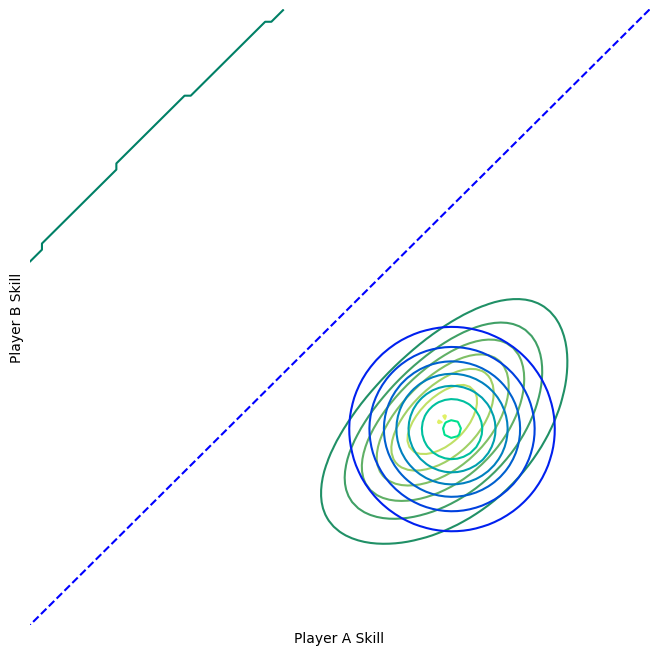

<Figure size 640x480 with 0 Axes>

In [6]:
num_players, n_iters, stepsize, num_samples_per_iter = 2, 1200, 0.0001, 80
params = (torch.zeros(num_players, requires_grad=True), torch.ones(num_players, requires_grad=True))
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def objective(params):
    return -batch_elbo(log_posterior_A_beat_B_20_times_1_arg, params[0], params[1], num_samples_per_iter)

def callback(params, t):
    if t % 25 == 0: print("Iteration {} lower bound {}".format(t, objective(params)))

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

def approx_posterior_2d(z1, z2):
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None: plot_isocontours(ax, f2, cmap='winter')
    if scatter_pts is not None: plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')
    plt.show(block=True)
    plt.draw()

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
print("\nFinal loss:")
callback(params, n_iters)

plot_2d_fun(posterior_A_beat_B_20_times, "Player A Skill", "Player B Skill", f2=approx_posterior_2d)

Optimizing variational parameters...


 47%|████▋     | 47/100 [00:00<00:00, 465.79it/s]

Iteration 0 lower bound 68.4005355834961
Iteration 25 lower bound 52.86326217651367
Iteration 50 lower bound 40.55809020996094
Iteration 75 lower bound 36.1768913269043


100%|██████████| 100/100 [00:00<00:00, 344.85it/s]



Final loss:
Iteration 100 lower bound 32.68263626098633


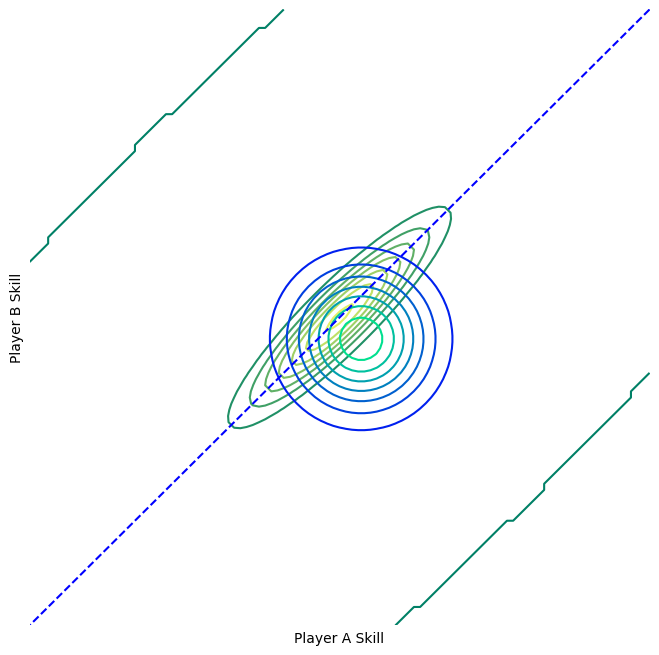

<Figure size 640x480 with 0 Axes>

In [7]:
n_iters, stepsize, num_samples_per_iter = 100, 0.0001, 50

def log_posterior_beat_each_other_20_times_1_arg(z1z2):
    return log_posterior_beat_each_other_20_times(z1z2[:, 0], z1z2[:, 1]).flatten()

def objective(params):
    return -batch_elbo(log_posterior_beat_each_other_20_times_1_arg, params[0], params[1], num_samples_per_iter)

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
print("\nFinal loss:")
callback(params, n_iters)

plot_2d_fun(posterior_beat_each_other_20_times, "Player A Skill", "Player B Skill", f2=approx_posterior_2d)

In [8]:
!curl -L -o premier-league-matches-19922022.zip\
    https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 81859  100 81859    0     0   117k      0 --:--:-- --:--:-- --:--:--  535k
Archive:  premier-league-matches-19922022.zip
  inflating: premier-league-matches.csv  


In [9]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])
    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_
    return games, names

games, names = load_games()
games = torch.LongTensor(games)

def log_games_likelihood(zs, games):
    winning_player_ixs = games[:, 0]
    losing_player_ixs = games[:, 1]
    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]
    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

In [10]:
num_players, n_iters, stepsize, num_samples_per_iter = 33, 200, 0.0001, 50
params = (torch.zeros(num_players, requires_grad=True), torch.zeros(num_players, requires_grad=True))
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def objective(params):
    return -batch_elbo(log_joint_probability, params[0], params[1], num_samples_per_iter)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
print("\nFinal loss:")
callback(params, n_iters)

Optimizing variational parameters...


  2%|▎         | 5/200 [00:00<00:03, 48.78it/s]

Iteration 0 lower bound 2231.838134765625


 20%|█▉        | 39/200 [00:00<00:01, 97.20it/s] 

Iteration 25 lower bound 1701.3717041015625


 31%|███       | 62/200 [00:00<00:01, 100.88it/s]

Iteration 50 lower bound 1584.42529296875


 46%|████▌     | 91/200 [00:01<00:01, 72.12it/s]

Iteration 75 lower bound 1554.8707275390625


 54%|█████▎    | 107/200 [00:01<00:01, 57.96it/s]

Iteration 100 lower bound 1537.8193359375


 68%|██████▊   | 136/200 [00:01<00:01, 61.60it/s]

Iteration 125 lower bound 1531.9090576171875


 81%|████████  | 162/200 [00:02<00:00, 75.45it/s]

Iteration 150 lower bound 1525.84912109375


 96%|█████████▌| 191/200 [00:02<00:00, 83.09it/s]

Iteration 175 lower bound 1521.88525390625


100%|██████████| 200/200 [00:02<00:00, 71.30it/s]


Final loss:
Iteration 200 lower bound 1521.64306640625


<ErrorbarContainer object of 3 artists>

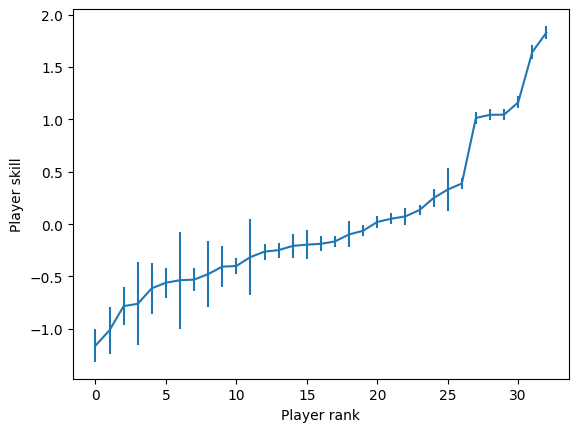

In [11]:
mean_skills = params[0].detach()
logstd_skills = params[1].detach()
var_skills = torch.exp(2 * logstd_skills)
order = torch.argsort(mean_skills)

plt.xlabel("Player rank"); plt.ylabel("Player skill")
plt.errorbar(range(num_players), mean_skills[order], var_skills[order])

In [12]:
for i in range(1,11): print(names[order[-i]])

Manchester City
Liverpool
Manchester Utd
Tottenham
Arsenal
Chelsea
Leicester City
Brentford
Wolves
West Ham


Arsenal
Liverpool


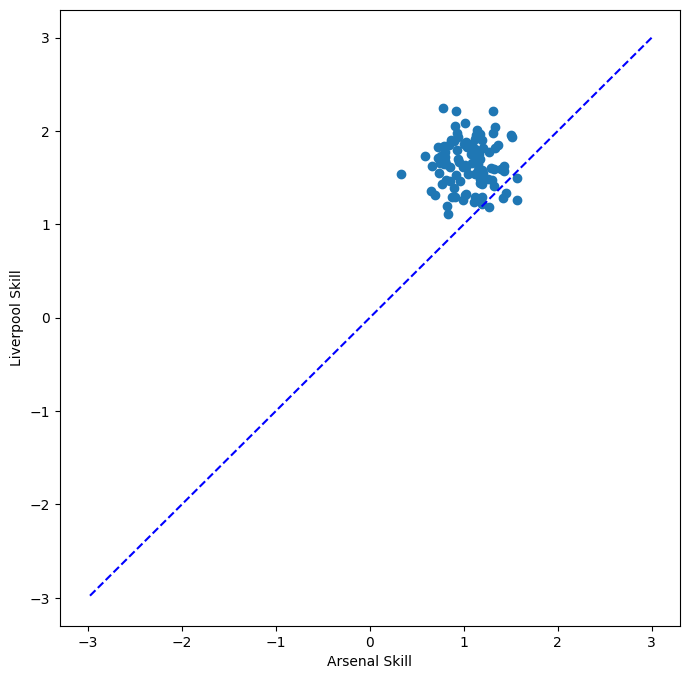

In [13]:
arsenal_ix, liverpool_ix = 0, 15
print(names[arsenal_ix])
print(names[liverpool_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')
plt.xlabel("Arsenal Skill")
plt.ylabel("Liverpool Skill")
plt.plot([3, -3], [3, -3], 'b--')

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)
plt.scatter(samples[:, arsenal_ix], samples[:, liverpool_ix])

In [14]:
def helper(A, B, n):
    m = mean_skills[A] - mean_skills[B]
    v = var_skills[A] + var_skills[B]
    formula = Normal(0,1).cdf(m / torch.sqrt(v))
    z = diag_gaussian_samples(mean_skills, logstd_skills, n)
    mc = np.count_nonzero(z[:, A] > z[:, B]) / z.shape[0]
    return formula, mc

formula, mc = helper(arsenal_ix, liverpool_ix, 10000)
print(f"Estimate using the formula: {formula}")
print(f"Estimate using simple MC: {mc}")

Estimate using the formula: 0.040347933769226074
Estimate using simple MC: 0.0369


In [15]:
print(f"Player with the 5th lowest mean skill: {names[order[4]]}")
formula, mc = helper(arsenal_ix, order[4], 10000)
print(f"Estimate using the formula: {formula}")
print(f"Estimate using simple MC: {mc}")

Player with the 5th lowest mean skill: Hull City
Estimate using the formula: 0.9988926649093628
Estimate using simple MC: 0.9991


# VAE with synthetic data

(np.float64(-1.145146781206131),
 np.float64(1.1347420752048492),
 np.float64(-0.577959755063057),
 np.float64(0.5907798200845719))

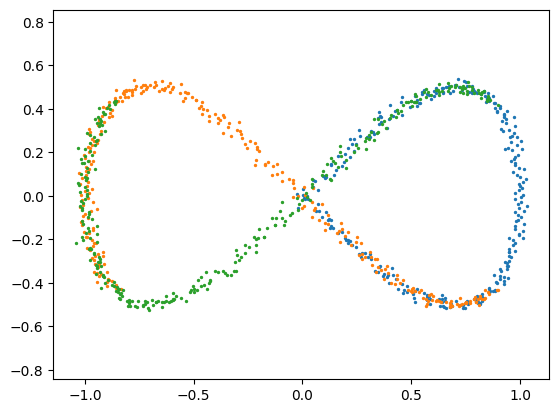

In [16]:
def make_banana_data(num_classes, num_per_class, noise_std=0.3):
    features = []
    labels = []
    for i in range(num_classes):
        theta = torch.linspace(0, np.pi, num_per_class) + i * (2 * np.pi / num_classes)
        x = torch.sin(theta) + noise_std * torch.randn_like(theta)
        y = torch.cos(theta) * (torch.sin(theta) + noise_std * torch.randn_like(theta))
        features.append(torch.stack([x, y], dim=1))
        labels.extend([i] * num_per_class)
    features = torch.cat(features, dim=0)
    labels = torch.tensor(labels).long()
    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], features[perm_ix]

num_clusters, samples_per_cluster = 3, 300
labels, data = make_banana_data(num_clusters, samples_per_cluster, 0.02)
for k in range(num_clusters): plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)
plt.axis("equal")

In [ ]:
def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

def batch_elbo(recognition_net, decoder_net, log_joint, data):
    q_m, q_std = recognition_net(data)
    z = diag_gaussian_samples(q_m, q_std, len(data))
    return torch.mean(log_joint(decoder_net, z, data) - diag_gaussian_logpdf(z, q_m, q_std))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension)
        self.std_net = nn.Linear(50, latent_dimension)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension)
        self.std_net = nn.Linear(50, data_dimension)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

data_dimension, latent_dimension = 2, 2
recognition_net = RecognitionNet(data_dimension, latent_dimension)
decoder_net = Decoder(latent_dimension, data_dimension)

def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean, np.log(0.1) + 0. * log_std)

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

In [17]:
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()}, {'params': decoder_net.parameters()}], lr=1e-3)
n_iters, minibatch_size = 2000, 300
dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(recognition_net, decoder_net, log_joint, minibatch)

def callback(t):
    if t % 100 == 0: print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

<ipython-input-17-9f30726a5ef6>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  0%|          | 4/2000 [00:00<00:53, 37.40it/s]

Iteration 0 lower bound -34.090675354003906


  6%|▌         | 111/2000 [00:01<00:25, 74.78it/s]

Iteration 100 lower bound -1.574777364730835


 10%|█         | 208/2000 [00:02<00:23, 76.56it/s]

Iteration 200 lower bound -1.2037054300308228


 16%|█▌        | 314/2000 [00:03<00:19, 87.80it/s]

Iteration 300 lower bound -1.153404712677002


 21%|██        | 411/2000 [00:05<00:30, 52.29it/s]

Iteration 400 lower bound -0.979287326335907


 25%|██▌       | 506/2000 [00:07<00:25, 57.52it/s]

Iteration 500 lower bound -0.8924641013145447


 31%|███       | 615/2000 [00:08<00:15, 89.71it/s]

Iteration 600 lower bound -0.8686020970344543


 36%|███▌      | 723/2000 [00:09<00:12, 105.94it/s]

Iteration 700 lower bound -0.8754794597625732


 41%|████      | 816/2000 [00:10<00:12, 93.78it/s]

Iteration 800 lower bound -0.8047335743904114


 46%|████▌     | 910/2000 [00:11<00:12, 87.95it/s]

Iteration 900 lower bound -0.8031473755836487


 51%|█████     | 1020/2000 [00:13<00:11, 86.95it/s]

Iteration 1000 lower bound -0.6781585812568665


 56%|█████▋    | 1126/2000 [00:13<00:05, 162.15it/s]

Iteration 1100 lower bound -0.7642248868942261


 62%|██████▏   | 1233/2000 [00:14<00:04, 166.38it/s]

Iteration 1200 lower bound -0.6461403965950012


 66%|██████▌   | 1323/2000 [00:15<00:03, 172.43it/s]

Iteration 1300 lower bound -0.7987936735153198


 71%|███████▏  | 1429/2000 [00:15<00:03, 164.76it/s]

Iteration 1400 lower bound -0.8526691794395447


 76%|███████▌  | 1518/2000 [00:16<00:02, 170.97it/s]

Iteration 1500 lower bound -0.7752146124839783


 81%|████████  | 1622/2000 [00:17<00:03, 113.43it/s]

Iteration 1600 lower bound -0.6443771123886108


 86%|████████▌ | 1715/2000 [00:18<00:02, 108.51it/s]

Iteration 1700 lower bound -0.7269988656044006


 91%|█████████ | 1817/2000 [00:18<00:01, 125.52it/s]

Iteration 1800 lower bound -0.7570447325706482


 96%|█████████▌| 1919/2000 [00:19<00:00, 110.56it/s]

Iteration 1900 lower bound -0.6630412936210632


100%|██████████| 2000/2000 [00:20<00:00, 98.16it/s] 


Text(0, 0.5, 'latent dimension 2')

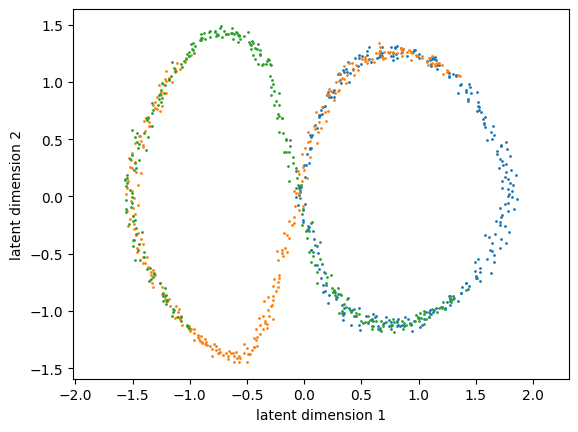

In [18]:
for k in range(num_clusters):
    cur_data = data[labels == k]
    transformed = recognition_net(cur_data)[0].detach()
    plt.scatter(transformed[:, 0], transformed[:, 1], s=1)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

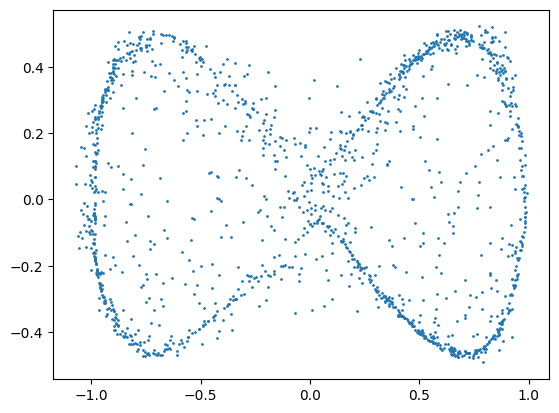

In [19]:
num_samples = 1500
samples = torch.randn(num_samples, latent_dimension)
transformed = decoder_net(samples)[0].detach()
plt.scatter(transformed[:, 0], transformed[:, 1], s=1)

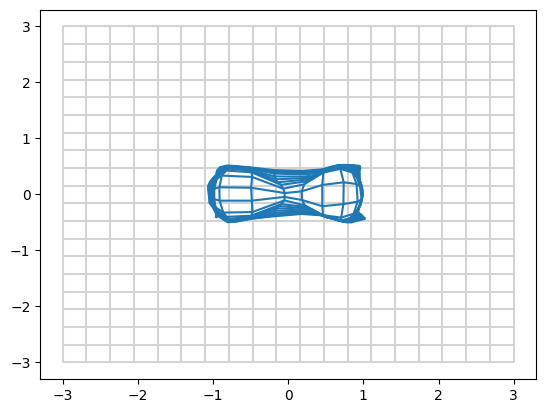

In [20]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()
grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 20), torch.linspace(-3, 3, 20))
plot_grid(grid_x, grid_y, ax=ax,  color="lightgrey")
distx, disty = f(grid_x, grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")
plt.show()

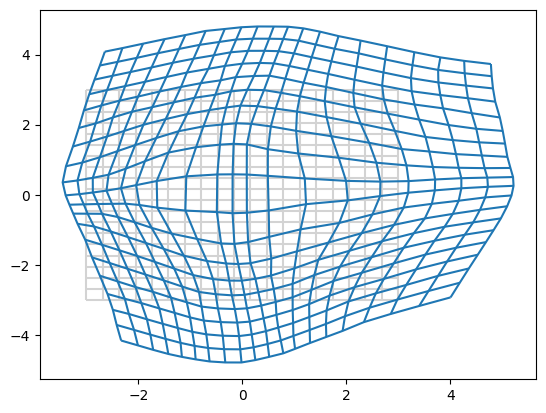

In [21]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()
grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 20), torch.linspace(-3, 3, 20))
plot_grid(grid_x, grid_y, ax=ax,  color="lightgrey")
distx, disty = f(grid_x, grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")
plt.show()